### Лабораторная 4

В этой задаче мы рассмотрим, как работают методы уменьшения размерности данных и кластеризации. Параллельно мы еще раз попрактикуемся в решении задачи классификации.

Мы будем работать с набором данных Samsung Human Activity Recognition. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее о функциях можно узнать по ссылке https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones), также известен род деятельности человека с телефоном в кармане: шел, стоял, лежал, сидел или шел вверх, или вниз по лестнице.

Сначала сделаем вид, что вид деятельности нам неизвестен, и попробуем кластеризовать людей исключительно по имеющимся признакам. Затем решаем задачу определения вида физической активности как задачу классификации.


In [2]:
# ! pip install tqdm

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17



In [4]:
!wget  -O 'X_train.txt' -q 'https://www.dropbox.com/scl/fi/61d589zshpj0a92xtef4c/X_train.txt?rlkey=aozwaa6i8a5eijyaxughc52rk&dl=0'
!wget  -O 'y_train.txt' -q 'https://www.dropbox.com/scl/fi/06m55z6m2sc2h99jju9rb/y_train.txt?rlkey=uo6i54o939ym5w4zjeprqkaqy&dl=0'
!wget  -O 'X_test.txt' -q 'https://www.dropbox.com/scl/fi/xo7lynpi183niopbl6d7p/X_test.txt?rlkey=3c3h3mbc69wdzyci3zq1cm7vq&dl=0'
!wget  -O 'y_test.txt' -q 'https://www.dropbox.com/scl/fi/w3dluvb2fv4zvri9zk0iy/y_test.txt?rlkey=18iap6tpqfh0h2dgdlfpvwu10&dl=0'

In [5]:
# измените путь до места, где лежат файлы, если необходимо
PATH_TO_SAMSUNG_DATA = "./"

In [6]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "y_train.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "X_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "y_test.txt")).astype(int)

In [7]:
# Проверяем размерность
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))


Для кластеризации нам не нужен целевой вектор, поэтому мы будем работать с комбинацией обучающей и тестовой выборок. Объедините X_train с X_test и y_train с y_test.

In [8]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

Определим количество уникальных значений меток целевого класса.


In [9]:
np.unique(y)
n_classes = np.unique(y).size
n_classes

6

Описание метрик классов
1. – Идет
2. – Идет вверх
3. – Идет вниз
4. – Сидит
5. – Стоит
6. – Лежит

Масштабируйте образец с помощью StandardScaler с параметрами по умолчанию.


In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Уменьшите количество измерений с помощью PCA, оставив столько компонентов, сколько необходимо для объяснения не менее 90% дисперсии исходных (масштабированных) данных. Используйте масштабированный набор данных и используйте <b>random_state=17  (константа RANDOM_STATE).</b>


In [11]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

Вопрос 1:

Какое минимальное количество главных компонентов, необходимо для покрытия 90% дисперсии масштабированных  данных?

In [12]:
pca.n_components_

65

Вопрос 2:
Какой процент дисперсии покрывается первой главной компонентой? Округлите до ближайшего процента.

In [13]:
print(f"{round(100*pca.explained_variance_ratio_[0])}%")

51%


Визуализируйте данные в проекции на первые две главных компоненты.

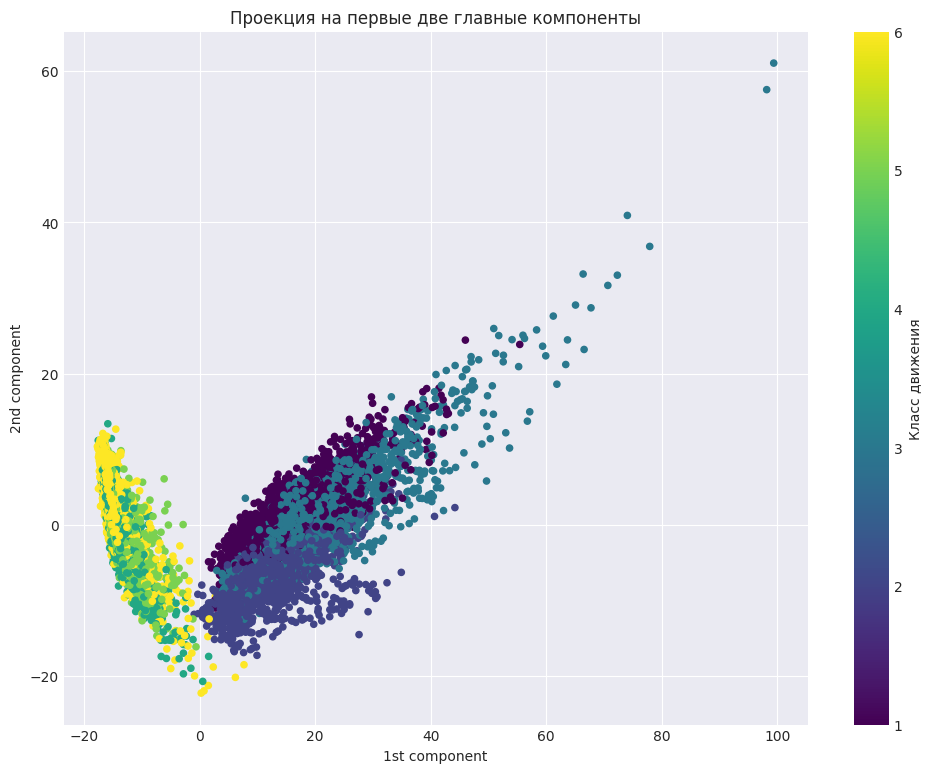

In [14]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');
plt.title('Проекция на первые две главные компоненты')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.colorbar(label='Класс движения')


Вопрос 3:
Если все получилось правильно, вы увидите ряд кластеров, практически идеально отделенных друг от друга. Сколько получилось кластеров и Какие виды деятельности входят в эти кластеры?


**Ответ:**
Визуально разделены 2 кластера:
* классы 4 - 6: сидит, стоит, лежит
* классы 1 - 3: идет, идет вверх, идет вниз

Выполните кластеризацию с помощью метода KMeans, обучая модель на данных полученных после применения PCA.

Параметры:

- n_clusters = (сколько необходимо кластеров?)

- n_init = 100

- random_state = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры должны иметь значения по умолчанию.


In [15]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

KMeans(n_clusters=6, n_init=100, random_state=17)

Визуализируйте данные в проекции на первые две главных компоненты. Раскрасьте точки в соответствии с полученными кластерами.

In [16]:
predicted_clusters = kmeans.labels_

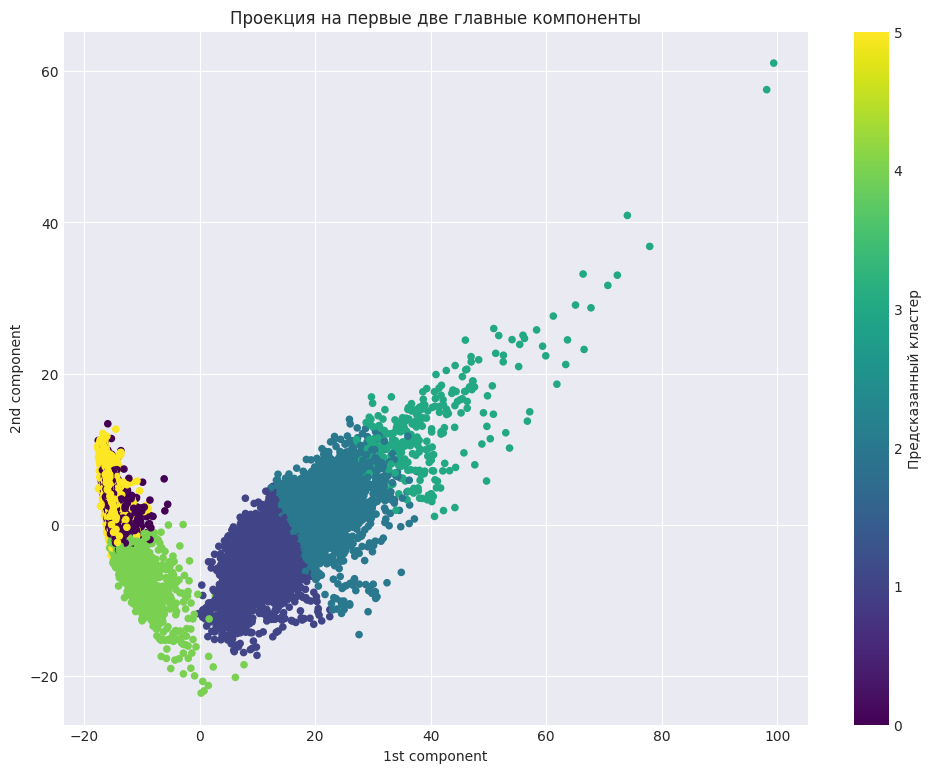

In [17]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_clusters, s=20, cmap='viridis')
plt.title('Проекция на первые две главные компоненты')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.colorbar(label='Предсказанный кластер')


Посмотрите на соответствие между метками кластеров и исходными метками классов и на каких видах деятельности алгоритм KMeans ошибается.

In [18]:
cluster_labels = predicted_clusters

tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,903,741,78,0,0,1722
going up the stairs,0,1241,296,5,2,0,1544
going down the stairs,0,320,890,196,0,0,1406
sitting,1235,1,0,0,450,91,1777
standing,1344,0,0,0,562,0,1906
laying,52,5,0,0,329,1558,1944
all,2631,2470,1927,279,1343,1649,10299


Мы видим, что для каждого класса (т. е. каждого вида деятельности) существует несколько кластеров. Давайте посмотрим на максимальный процент объектов в классе, отнесенных к одному кластеру. Это будет простая метрика, характеризующая, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса «идет вниз» (1406 экземпляров), распределение кластеров таково:

кластер 1 – 900
кластер 3 – 500
кластер 6 - 6,
тогда такая доля будет 900/1406 ≈
  0,64.


In [19]:
cut = tab.iloc[:tab.shape[0]-1, : tab.shape[1]-1]
classes = cut.index
for c in classes:
    biggest_cluster = cut.loc[c].idxmax()
    # print(f"{c} "+biggest_cluster)
    cnt = cut.loc[c, biggest_cluster]
    total = tab['all'][c]
    measure = cnt/total
    print(f"class {c} measure = {round(measure,2)}")

class walking measure = 0.52
class going up the stairs measure = 0.8
class going down the stairs measure = 0.63
class sitting measure = 0.69
class standing measure = 0.71
class laying measure = 0.8


Вопрос 4:
Какая деятельность лучше других отделена от остальных на основе метрики, описанной выше?

**Ответ:**
going up the stairs со значением меры = 0.8

Видно, что kMeans не очень хорошо различает виды действий. Используйте метод локтя (Elbow Method), чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные, которые мы используем, такие же, как и раньше, меняем только n_clusters.

Визуализируете изменение inertia на графике

In [20]:
# ! pip install ipywidgets

In [21]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

/tmp/ipykernel_225589/1454820091.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Зависимость инерции от числа кластеров')

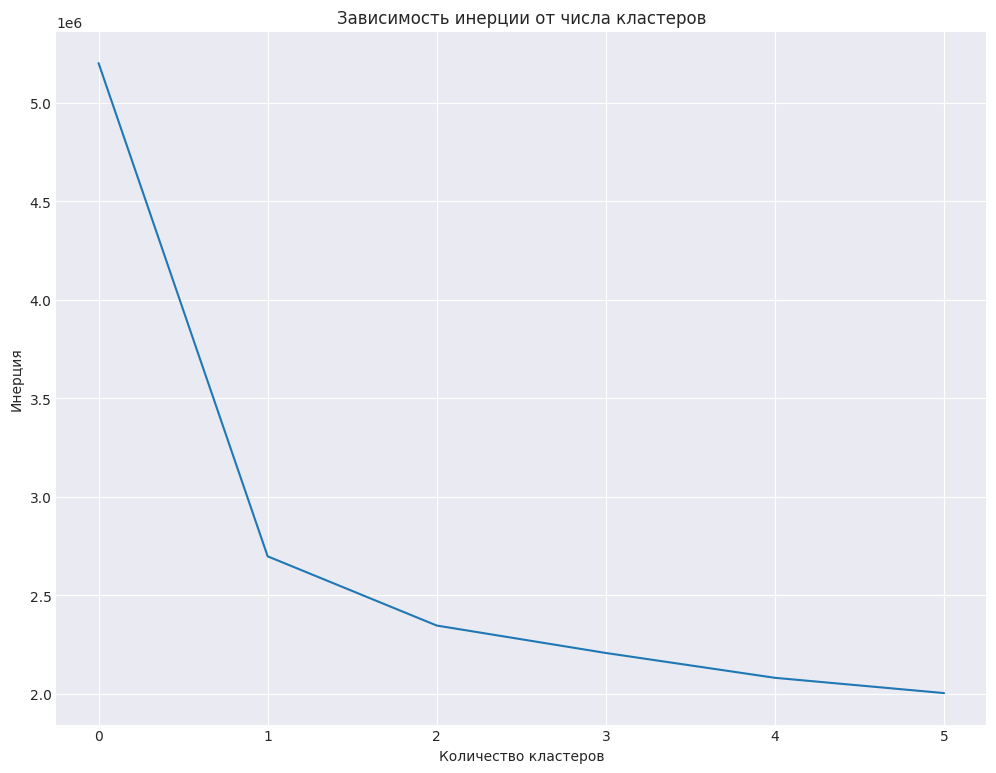

In [34]:
sns.lineplot(data= inertia)
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Зависимость инерции от числа кластеров')

Вопрос 5:
Сколько кластеров было бы оптимально выбрать по методу локтя?

Если у нас мало кластеров это можно увидеть и на графике, но если кластеров много или тяжело определить "на граз" по графику, то можно расчитать по формуле ниже

*(d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i]))*

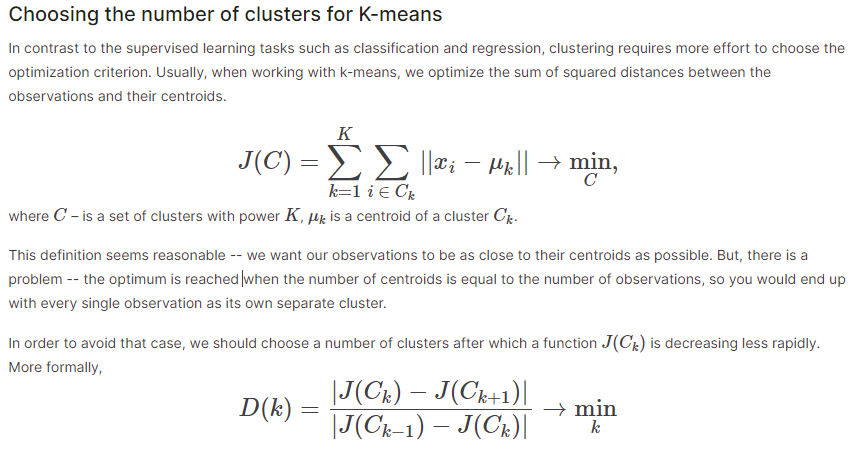



---



Попробуем другой алгоритм кластеризации - Agglomerative clustering.

In [22]:
# ag = AgglomerativeClustering(n_clusters=n_classes,
#                              linkage='ward').fit(X_pca)


Рассчитайте Adjusted Rand Index (sklearn.metrics) для полученной кластеризации и для KMeans с параметрами из 4-го вопроса.


In [23]:
# ВАШ КОД ЗДЕСЬ

Вопрос 6:
Выберите все правильные утверждения.

Утверждения:

- По данным ARI, KMeans справляется с кластеризацией хуже, чем Agglomerative clustering.
- Для ARI не имеет значения, какие теги присвоены кластеру, имеет значение только разбиение экземпляров на кластеры.
- В случае случайного разбиения на кластеры ARI будет близок к нулю.



---



Можно заметить, что задача не очень хорошо решается, когда мы пытаемся обнаружить несколько кластеров (>2). Теперь давайте решим задачу классификации, учитывая, что данные размеченны.

Для классификации используйте sklearn.svm.LinearSVC.

Выберите гиперпараметр C для LinearSVC с помощью GridSearchCV.

Обучите новый StandardScaler на обучающем наборе (со всеми исходными функциями), примените масштабирование к тестовому набору.
В GridSearchCV укажите cv = 3.


In [24]:
# # ВАЩ КОД ЗДЕСЬ
# scaler = StandardScaler()
# X_train_scaled =
# X_test_scaled =

In [25]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [26]:
# %%time
# # ВАШ КОД ЗДЕСЬ
# best_svc = None

Вопрос 7:

Какое значение гиперпараметра C было выбрано лучшим на основе перекрестной проверки?

In [27]:
# y_predicted = best_svc.predict(X_test_scaled)

In [28]:
# tab = pd.crosstab(y_test, y_predicted, margins=True)
# tab.index = ['walking', 'climbing up the stairs',
#              'going down the stairs', 'sitting', 'standing', 'laying', 'all']
# tab.columns = ['walking', 'climbing up the stairs',
#              'going down the stairs', 'sitting', 'standing', 'laying', 'all']
# tab


Вопрос 8:
Какой тип активности SVM хуже всего обнаруживает по метрике precision? И recall?




---



Обучите снова LinearSVC, но добавьте PCA.

Используйте X_train_scaled и X_test_scaled.
Обучите PCA c теми же параметрами, что и раньше, на масштабированном обучающем наборе, примените масштабирование к тестовому набору.
Выберите гиперпараметр C посредством перекрестной проверки на обучающем наборе с PCA-преобразованием. Не забывайте использовать фиксированный <b>random_state=17  (константа RANDOM_STATE).</b>


Вы можете заметить насколько быстрее идет обучение

In [29]:
# # ВАШ КОД ЗДЕСЬ


Вопрос 9:

Какая разница между лучшей точностью (accuracy) перекрестной проверки в случае всех 561 исходной характеристик и во втором случае, когда применялся метод главных компонент? Округлите до ближайшего процента.


In [30]:
# # ВАШ КОД ЗДЕСЬ
